In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (
    Dropout,
)
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
from tensorflow.keras.optimizers import Adam
import xml.etree.ElementTree as ET
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
import os

In [2]:
# Function to parse XML files
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Initialize variables for the image details
    label = None

    # Parse XML to get the label
    for member in root.findall("object"):
        label = member.find("name").text
        # Assuming we only need the label, not bounding box coordinates

    return label

In [3]:
# Paths
annotations_dir = "1/annotations"
images_dir = "1/images/"

# Initialize lists to hold data
image_data = []
labels = []

# Loop over each XML file in the annotations folder
for xml_file in os.listdir(annotations_dir):
    if xml_file.endswith(".xml"):
        # Parse the XML to get the label
        xml_path = os.path.join(annotations_dir, xml_file)
        label = parse_xml(xml_path)

        # Corresponding image file
        image_file = xml_file.replace(".xml", ".png")
        image_path = os.path.join(images_dir, image_file)

        # Check if the image file exists
        if os.path.exists(image_path):
            # Read and resize image
            image = cv2.imread(image_path)
            image = cv2.cvtColor(
                image, cv2.COLOR_BGR2RGB
            )  # Ensure 3 channels and correct color order for Keras
            image = cv2.resize(image, (128, 128))  # Resize to 128x128

            # Append data to lists
            image_data.append(image)  # Keep image as 2D array
            labels.append(label)

# Convert to numpy arrays
X = np.array(image_data)
y = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
y_categorical = to_categorical(y_encoded, num_classes=num_classes)

print(f"Shape of X: {X.shape}")
print(f"Shape of y_categorical: {y_categorical.shape}")
print(f"Number of classes: {num_classes}")
print(f"Class labels: {label_encoder.classes_}")

Shape of X: (853, 128, 128, 3)
Shape of y_categorical: (853, 3)
Number of classes: 3
Class labels: ['mask_weared_incorrect' 'with_mask' 'without_mask']


## Prepare Data for MobileNetV2

In [4]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Split data into training and validation sets
# Ensure X contains the images and y_categorical contains the one-hot encoded labels
X_train, X_val, y_train, y_val = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

# Apply MobileNetV2 preprocessing
# MobileNetV2 expects pixel values in the range [-1, 1]
# The preprocess_input function handles this.
X_train_processed = preprocess_input(X_train.astype("float32"))
X_val_processed = preprocess_input(X_val.astype("float32"))

print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"X_val_processed shape: {X_val_processed.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train_processed shape: (682, 128, 128, 3)
X_val_processed shape: (171, 128, 128, 3)
y_train shape: (682, 3)
y_val shape: (171, 3)


## Define and Compile MobileNetV2 Model

In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# num_classes should be defined from the label encoding step in the previous cell

# Load MobileNetV2 base model, excluding the top classification layer
base_model = MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(128, 128, 3)
)

# Freeze the layers of the base model (so we only train our custom head initially)
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(
    x
)  # Added l2 regularization
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation="softmax")(
    x
)  # num_classes is from the data loading cell

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

## Train the Model

In [6]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=5, min_lr=0.00001, verbose=1
)
model_checkpoint = ModelCheckpoint(
    "best_mask_detector_mobilenetv2.keras",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
)

epochs = 50
batch_size = 32

print("Starting training...")
history = model.fit(
    X_train_processed,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_processed, y_val),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
)

print("Training complete.")

Starting training...
Epoch 1/50
22/22 [==============================] - 12s 341ms/step - loss: 2.9309 - accuracy: 0.6804 - val_loss: 2.4581 - val_accuracy: 0.7953 - lr: 0.0010
Epoch 2/50
22/22 [==============================] - 6s 262ms/step - loss: 2.2273 - accuracy: 0.7962 - val_loss: 2.0691 - val_accuracy: 0.8246 - lr: 0.0010
Epoch 3/50
22/22 [==============================] - 4s 188ms/step - loss: 1.8371 - accuracy: 0.8328 - val_loss: 1.8041 - val_accuracy: 0.8012 - lr: 0.0010
Epoch 4/50
22/22 [==============================] - 4s 185ms/step - loss: 1.5533 - accuracy: 0.8563 - val_loss: 1.6240 - val_accuracy: 0.8246 - lr: 0.0010
Epoch 5/50
22/22 [==============================] - 4s 174ms/step - loss: 1.3331 - accuracy: 0.8827 - val_loss: 1.4839 - val_accuracy: 0.8187 - lr: 0.0010
Epoch 6/50
22/22 [==============================] - 4s 194ms/step - loss: 1.1756 - accuracy: 0.8915 - val_loss: 1.4027 - val_accuracy: 0.8246 - lr: 0.0010
Epoch 7/50
22/22 [==============================

## Evaluate the Model

Validation Loss: 0.8067
Validation Accuracy: 0.8304


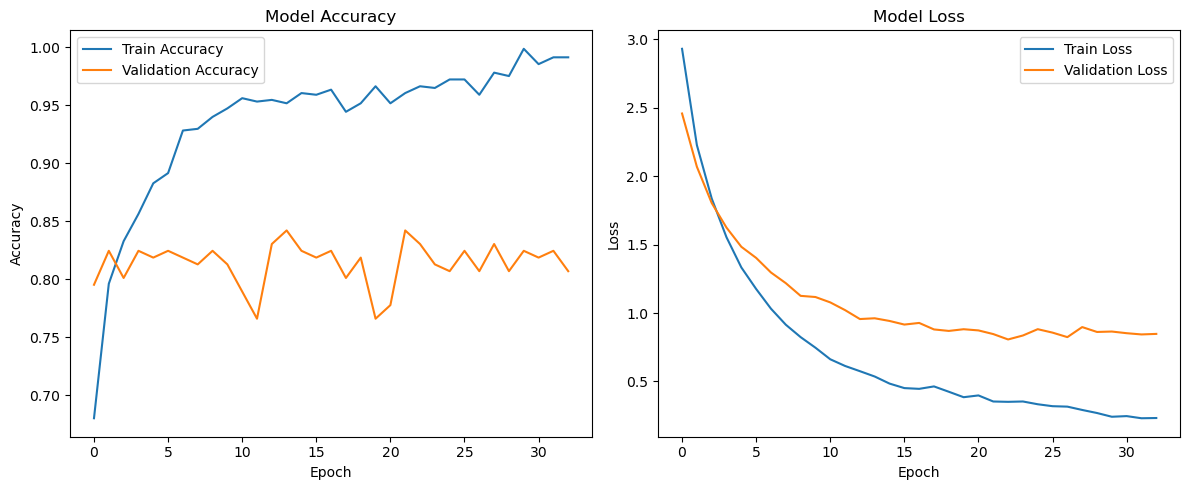

6/6 [==============================] - 2s 160ms/step

Classification Report:
                       precision    recall  f1-score   support

mask_weared_incorrect       0.75      0.43      0.55         7
            with_mask       0.86      0.94      0.90       127
         without_mask       0.69      0.54      0.61        37

             accuracy                           0.83       171
            macro avg       0.77      0.64      0.68       171
         weighted avg       0.82      0.83      0.82       171


Confusion Matrix:
[[  3   3   1]
 [  0 119   8]
 [  1  16  20]]


In [7]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val_processed, y_val, verbose=0)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Further evaluation (e.g., classification report, confusion matrix)
from sklearn.metrics import classification_report, confusion_matrix

y_pred_probabilities = model.predict(X_val_processed)
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
y_true_classes = np.argmax(
    y_val, axis=1
)  # Convert one-hot encoded y_val back to class indices

# Ensure label_encoder is available from the data loading cell
if "label_encoder" in globals() and hasattr(label_encoder, "classes_"):
    print("\nClassification Report:")
    print(
        classification_report(
            y_true_classes, y_pred_classes, target_names=label_encoder.classes_
        )
    )

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true_classes, y_pred_classes))
else:
    print("\nClassification Report (numeric labels):")
    print(classification_report(y_true_classes, y_pred_classes))
    print("\nConfusion Matrix (numeric labels):")
    print(confusion_matrix(y_true_classes, y_pred_classes))
    print(
        "\nNote: 'label_encoder' not found or not fitted. Class names will not be shown in the report."
    )

## Fine-tuning

Number of layers in the base model:  154
Layer block_15_depthwise_relu unfrozen.
Layer block_15_project unfrozen.
Layer block_15_project_BN unfrozen.
Layer block_15_add unfrozen.
Layer block_16_expand unfrozen.
Layer block_16_expand_BN unfrozen.
Layer block_16_expand_relu unfrozen.
Layer block_16_depthwise unfrozen.
Layer block_16_depthwise_BN unfrozen.
Layer block_16_depthwise_relu unfrozen.
Layer block_16_project unfrozen.
Layer block_16_project_BN unfrozen.
Layer Conv_1 unfrozen.
Layer Conv_1_bn unfrozen.
Layer out_relu unfrozen.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                  

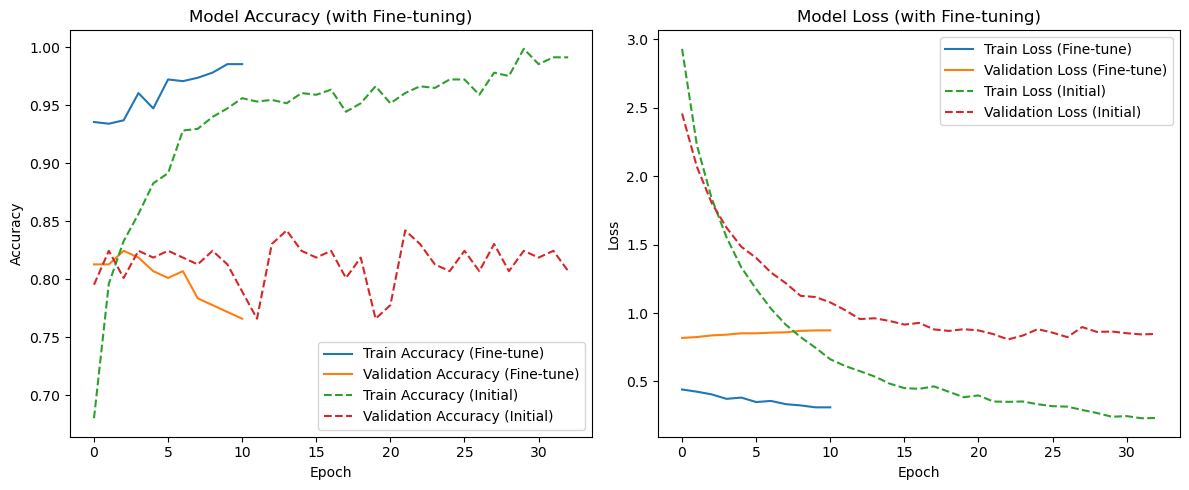

In [8]:
print("Number of layers in the base model: ", len(base_model.layers))
# Unfreeze from a certain layer onwards. The exact number depends on the model architecture and experimentation.
# For MobileNetV2, you might start by unfreezing the last block or two.
fine_tune_at = -15

for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True
    print(f"Layer {layer.name} unfrozen.")

# Re-compile the model with a very low learning rate for fine-tuning
optimizer_fine_tune = Adam(learning_rate=1e-5)  # Very low learning rate for fine-tuning
model.compile(
    optimizer=optimizer_fine_tune, loss="categorical_crossentropy", metrics=["accuracy"]
)

model.summary()  # Check the updated trainable parameters

# Define checkpoint callback for fine-tuning
model_checkpoint_finetune = ModelCheckpoint(
    "best_mask_detector_mobilenetv2_finetuned.keras",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    verbose=1,
)

print("\nStarting fine-tuning...")
# You might want to train for fewer epochs during fine-tuning
fine_tune_epochs = 20
total_epochs = history.epoch[-1] + 1 + fine_tune_epochs

history_fine_tune = model.fit(
    X_train_processed,
    y_train,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1,  # Start from where the last training stopped
    batch_size=batch_size,
    validation_data=(X_val_processed, y_val),
    callbacks=[
        early_stopping,
        reduce_lr,
        model_checkpoint_finetune,  # Added checkpoint callback for fine-tuning
    ],
)

print("Fine-tuning complete.")

# Evaluate after fine-tuning
loss_ft, accuracy_ft = model.evaluate(X_val_processed, y_val, verbose=0)
print(f"Fine-tuned Validation Loss: {loss_ft:.4f}")
print(f"Fine-tuned Validation Accuracy: {accuracy_ft:.4f}")

# Plot fine-tuning history (optional, can append to original history or plot separately)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_fine_tune.history["accuracy"], label="Train Accuracy (Fine-tune)")
plt.plot(
    history_fine_tune.history["val_accuracy"], label="Validation Accuracy (Fine-tune)"
)
plt.plot(
    history.history["accuracy"], label="Train Accuracy (Initial)", linestyle="--"
)  # Plot initial history too
plt.plot(
    history.history["val_accuracy"],
    label="Validation Accuracy (Initial)",
    linestyle="--",
)
plt.title("Model Accuracy (with Fine-tuning)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_fine_tune.history["loss"], label="Train Loss (Fine-tune)")
plt.plot(history_fine_tune.history["val_loss"], label="Validation Loss (Fine-tune)")
plt.plot(history.history["loss"], label="Train Loss (Initial)", linestyle="--")
plt.plot(history.history["val_loss"], label="Validation Loss (Initial)", linestyle="--")
plt.title("Model Loss (with Fine-tuning)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

## Load and Evaluate Best Models

In [9]:
from tensorflow.keras.models import load_model

# Load the best model saved during the fine-tuning phase
try:
    best_finetuned_model = load_model("best_mask_detector_mobilenetv2_finetuned.keras")
    loss_best_ft, accuracy_best_ft = best_finetuned_model.evaluate(
        X_val_processed, y_val, verbose=0
    )
    print(
        f"Best Fine-tuned Model (from checkpoint) Validation Loss: {loss_best_ft:.4f}"
    )
    print(
        f"Best Fine-tuned Model (from checkpoint) Validation Accuracy: {accuracy_best_ft:.4f}"
    )

    # Generate classification report for the best fine-tuned model
    ft_preds = best_finetuned_model.predict(X_val_processed)
    ft_pred_classes = np.argmax(ft_preds, axis=1)
    ft_true_classes = np.argmax(y_val, axis=1)

    print("\nClassification Report for Best Fine-tuned Model:")
    print(
        classification_report(
            ft_true_classes, ft_pred_classes, target_names=label_encoder.classes_
        )
    )

    print("\nConfusion Matrix for Best Fine-tuned Model:")
    print(confusion_matrix(ft_true_classes, ft_pred_classes))

except (OSError, IOError) as e:
    print(f"Could not load fine-tuned model: {e}")

# Also, load and evaluate the best model from the initial training for comparison
try:
    best_initial_model = load_model("best_mask_detector_mobilenetv2.keras")
    loss_initial, accuracy_initial = best_initial_model.evaluate(
        X_val_processed, y_val, verbose=0
    )
    print(f"\nBest Initial Model (from checkpoint) Validation Loss: {loss_initial:.4f}")
    print(
        f"Best Initial Model (from checkpoint) Validation Accuracy: {accuracy_initial:.4f}"
    )

    # Generate classification report for the best initial model
    initial_preds = best_initial_model.predict(X_val_processed)
    initial_pred_classes = np.argmax(initial_preds, axis=1)

    print("\nClassification Report for Best Initial Model:")
    print(
        classification_report(
            ft_true_classes, initial_pred_classes, target_names=label_encoder.classes_
        )
    )

    print("\nConfusion Matrix for Best Initial Model:")
    print(confusion_matrix(ft_true_classes, initial_pred_classes))

except (OSError, IOError) as e:
    print(f"Could not load initial model: {e}")

# Compare the models
if "accuracy_best_ft" in locals() and "accuracy_initial" in locals():
    if accuracy_best_ft > accuracy_initial:
        print("\nThe fine-tuned model performs better!")
        best_model = best_finetuned_model
    else:
        print("\nThe initial model performs better!")
        best_model = best_initial_model

    print(f"Best model accuracy: {max(accuracy_best_ft, accuracy_initial):.4f}")

Best Fine-tuned Model (from checkpoint) Validation Loss: 0.8364
Best Fine-tuned Model (from checkpoint) Validation Accuracy: 0.8246
6/6 [==============================] - 2s 155ms/step

Classification Report for Best Fine-tuned Model:
                       precision    recall  f1-score   support

mask_weared_incorrect       1.00      0.43      0.60         7
            with_mask       0.87      0.91      0.89       127
         without_mask       0.65      0.59      0.62        37

             accuracy                           0.82       171
            macro avg       0.84      0.65      0.70       171
         weighted avg       0.82      0.82      0.82       171


Confusion Matrix for Best Fine-tuned Model:
[[  3   3   1]
 [  0 116  11]
 [  0  15  22]]

Best Initial Model (from checkpoint) Validation Loss: 0.9615
Best Initial Model (from checkpoint) Validation Accuracy: 0.8421
6/6 [==============================] - 2s 115ms/step

Classification Report for Best Initial Model:
   